# Tempo de passagem

Entende-se por tempo de passagem, o tempo médio necessário para que as árvores de uma classe diamétrica passe à seguinte.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
continuo = pd.read_csv('https://raw.githubusercontent.com/Gorgens/treelab/master/manejo/inventarioContinuo.csv')
continuo.sample(10)

,parcela,arv,comum.nome,cientifico.nome,familia.nome,dap.2012,tipo,vert.2012,Luz.2012,Hcom.2012,Htot.2012,dap.2014,UTM.leste,UTM.norte
0,T01,2,macucu,Licania guianensis,Chrysobalanaceae,10.3,O,S,2.0,4.59,7.83,10.3,778459.6729,9586871.539
1,T01,5,casca seca,Licania canescens,Chrysobalanaceae,14.6,O,S,2.0,9.16,10.27,14.9,778444.1712,9586870.399
2,T01,6,cajuacu,Anacardium spruceanum,Anacardiaceae,78.8,O,E,1.0,21.06,31.65,78.9,778443.5294,9586872.461
3,T01,7,breu branco,Protium paniculatum,Burseraceae,14.7,O,S,2.0,7.35,11.54,14.7,778443.2246,9586869.534
4,T01,9,breu branco,Protium paniculatum,Burseraceae,10.6,O,E,3.0,4.90,6.91,10.6,778436.1941,9586869.460


## Centro de classe

1. Obter centro de classe
2. Obter incremento anual
3. Agrupamento de dados por classe diamétrica

In [3]:
intervaloClasse = 10.0
diametroMin = 10.0
classeMax = ((max(continuo['dap.2012']) // intervaloClasse) + 1) * intervaloClasse

intervalos = list(np.arange(diametroMin, classeMax, intervaloClasse))
# intervalos = list(map((lambda x: x - 0.001), intervalos))
intervalos = [(x - 0.001) for x in intervalos]
centros = [round(x + intervaloClasse/2.0, 0) for x in intervalos[:-1]]

intervaloMedicao = 2

continuo = continuo[continuo['dap.2012'] >= diametroMin]
continuo['centroClasse'] = pd.cut(continuo['dap.2012'], bins=intervalos, labels=centros)
continuo['incremento'] = continuo['dap.2014'] - continuo['dap.2012']
continuo['incremento'] = continuo['incremento'].apply(lambda x: x/intervaloMedicao)

# print(continuo.shape)

In [4]:
filteredContinuo = continuo[(continuo['comum.nome'] != 'morta') & 
                            (continuo['incremento'] >= 0) & 
                            (continuo['incremento'].notnull())]

# print(filteredContinuo.shape)
incrementoClasse = filteredContinuo.pivot_table(values='incremento', index='centroClasse', aggfunc=['mean', 'count'])
incrementoClasse = incrementoClasse.reset_index()
incrementoClasse = pd.DataFrame(incrementoClasse.to_records())
incrementoClasse.drop('index', axis=1, inplace = True)
incrementoClasse.columns = ['centroClasse', 'meanInc', 'nArv']
incrementoClasse

,centroClasse,meanInc,nArv
0,15.0,0.241061,688
1,25.0,0.314979,237
2,35.0,0.538547,358
3,45.0,0.641772,395
4,55.0,0.629200,250
5,65.0,0.642073,82
6,75.0,0.526190,42
7,85.0,0.620000,40
8,95.0,0.650000,16
9,105.0,0.440000,5


## Modelagem do tempo de passagem

1. Filtrar centros de classe com observações
2. Modelar comportamento do incremento médio em função do contro de classe
3. Estimar tempo de passagem

In [5]:
minimoObservacoes = 30
incrementoClasseReduzido = incrementoClasse[incrementoClasse['nArv'] > minimoObservacoes]
incrementoClasseReduzido

,centroClasse,meanInc,nArv
0,15.0,0.241061,688
1,25.0,0.314979,237
2,35.0,0.538547,358
3,45.0,0.641772,395
4,55.0,0.629200,250
5,65.0,0.642073,82
6,75.0,0.526190,42
7,85.0,0.620000,40


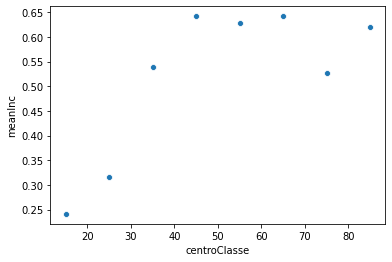

In [6]:
ax = sns.scatterplot(x = incrementoClasseReduzido['centroClasse'], y = incrementoClasseReduzido['meanInc'])

In [7]:
def growthLogistic(cc, a, b, c):
  return c / (1+a * np.exp(-b*cc))

p0 = np.random.exponential(size = 3)
bounds = (0, [100., 3., 1])

x = np.array(incrementoClasseReduzido['centroClasse']) + 1
y = np.array(incrementoClasseReduzido['meanInc'])

(a,b,c),cov = optim.curve_fit(growthLogistic, x, y, bounds = bounds, p0=p0)
a,b,c

(14.458195403970455, 0.12010707176813167, 0.6190890252915693)

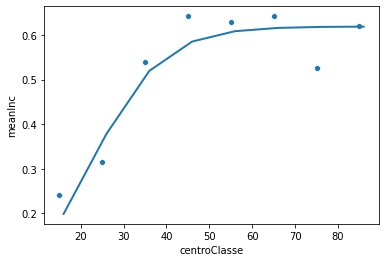

In [8]:
ax = sns.scatterplot(x = incrementoClasseReduzido['centroClasse'], y = incrementoClasseReduzido['meanInc'])
plt.plot(x, growthLogistic(x, 14.4606, 0.1201, 0.6191), linewidth=2)

In [9]:
incrementoClasse['incrementoModelo'] = growthLogistic(incrementoClasse['centroClasse'], 14.4606, 0.1201, 0.6191)
incrementoClasse['tempoPassagem'] = incrementoClasse['incrementoModelo'].apply(lambda x: intervaloClasse/x)
incrementoClasse.sort_values(by=['centroClasse'])

,centroClasse,meanInc,nArv,incrementoModelo,tempoPassagem
0,15.0,0.241061,688,0.182801,54.704221
1,25.0,0.314979,237,0.360329,27.752435
2,35.0,0.538547,358,0.509092,19.642827
3,45.0,0.641772,395,0.581304,17.202701
4,55.0,0.629200,250,0.607220,16.468484
5,65.0,0.642073,82,0.615477,16.247563
6,75.0,0.526190,42,0.618005,16.181089
7,85.0,0.620000,40,0.618770,16.161088
8,95.0,0.650000,16,0.619001,16.155070
9,105.0,0.440000,5,0.619070,16.153259
